## Shapefile georeferencer

This notebook was designed to georefence a shapefile using a control point file with three dimensional coordinates. 

For now the notebook works with line shapefiles only, and uses a first order polynomial transformation for georeferencing. 

This notebook requires the Python modules numpy, scipy, geopandas, shapely and sympy.

## Import some Python modules

In [230]:
import os
import itertools
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize

import shapely
import sympy

## Some parameters for georeferencing

In [231]:
#geometry = 

# shapefile to be projected
shpfile = 'data/L48_1_MG_TM fractures.shp'

# shapefile with control points, ie points for which the coordinates are known
#control_pt_file = 'data/L48_1_MG coord locations.shp'
control_pt_file = 'data/L48_1_MG_control_pts_mod.shp'

# columns in the control point file that designate real coordinates
cp_x_col = 'northing'
cp_y_col = 'easting'
cp_z_col = 'elevation'

# polynomial order for the transform function.
# use 1 or 2. 2nd order gives much better results in most cases, but needs more control pts.
order = 2

# absolute and relative tolerance of optimization algorithm to find the georeference transofrmation
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html
# feel free to adjust these values if the georeferencing error is too high
xtol = 1e-12
ftol = 1e-12

# this is to try out if guessingg the initial best parameters for the transform works. Seems to have no effect, so best leave on 'horizontal'
approximate_orientation = 'horizontal'

## Optional parameters for projecting the 3D georefenced shapefile/lines onto a 2D plane

In [232]:
# Switch to turn projection to a plane on or off
project_shapefile = True

# shapefile with three points that define a plane
# if the file contains more than three pts then the first three are used only
plane_pt_file = 'data/L48_1_MG_plane_projection_pts.shp'

# columns in the plane point file that designate real coordinates
pp_x_col = 'northing'
pp_y_col = 'easting'
pp_z_col = 'elevation'

## Read control point file

In [233]:
cp = gp.read_file(control_pt_file)
cp

,id,northing,easting,elevation,geometry
0,1.0,5742957.092,3588783.315,486.818,POINT (2026.601 -2236.399)
1,2.0,5742950.091,3588784.181,489.146,POINT (3745.403 -1620.575)
2,3.0,5742961.891,3588784.179,491.471,POINT (594.475 -959.583)
3,4.0,5742955.344,3588784.760,491.381,POINT (2465.584 -1001.695)
4,NaN,5742960.122,3588785.829,492.735,POINT (1303.852 -612.002)
5,NaN,5742959.543,3588784.720,491.175,POINT (1352.190 -1047.155)
6,NaN,5742960.563,3588783.929,490.448,POINT (1009.730 -1275.061)
7,NaN,5742960.680,3588783.291,488.857,POINT (976.612 -1760.686)
8,NaN,5742951.182,3588783.643,486.365,POINT (3453.906 -2291.213)
9,NaN,5742949.472,3588783.580,486.772,POINT (3872.096 -2206.428)


In [234]:
src = np.array([g.coords[:][0] for g in cp.geometry])
dst = np.array(list(zip(cp[cp_x_col], cp[cp_y_col], cp[cp_z_col])))

print('source coords extracted from control pt file:n', src)
print('to be projected to:n', dst)

source coords extracted from control pt file:n [[ 2026.600641   -2236.39859409]
 [ 3745.40348893 -1620.57498587]
 [  594.47528058  -959.58308778]
 [ 2465.58406617 -1001.69516552]
 [ 1303.85225545  -612.00243682]
 [ 1352.19004564 -1047.15478248]
 [ 1009.72993149 -1275.06126473]
 [  976.61179963 -1760.68632727]
 [ 3453.90587901 -2291.21328058]
 [ 3872.09594357 -2206.42834611]
 [ 4038.40923014 -2085.55647722]
 [ 2283.28414554 -1918.77514907]
 [ 1908.17219302 -1221.13968454]
 [ 2072.40074422 -1006.28871815]
 [ 3274.12119293 -1690.92523543]
 [ 2982.34575363 -1338.21298869]
 [ 3052.41189315 -2448.84171029]
 [ 2837.32997651 -2098.54186916]
 [  610.7066482  -1775.01396674]]
to be projected to:n [[5.74295709e+06 3.58878331e+06 4.86818000e+02]
 [5.74295009e+06 3.58878418e+06 4.89146000e+02]
 [5.74296189e+06 3.58878418e+06 4.91471000e+02]
 [5.74295534e+06 3.58878476e+06 4.91381000e+02]
 [5.74296012e+06 3.58878583e+06 4.92735000e+02]
 [5.74295954e+06 3.58878472e+06 4.91175000e+02]
 [5.74296056e+06

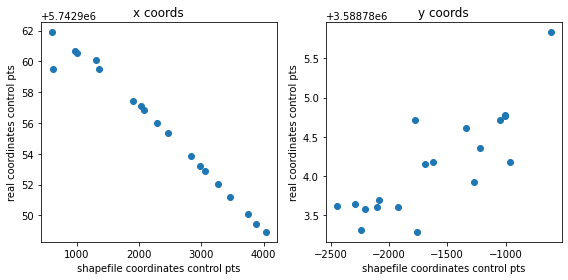

In [235]:
fig, axs = pl.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(src[:, 0], dst[:, 0])
axs[1].scatter(src[:, 1], dst[:, 1])

for ax in axs:
    ax.set_xlabel('shapefile coordinates control pts')
    ax.set_ylabel('real coordinates control pts')

axs[0].set_title('x coords')
axs[1].set_title('y coords')

fig.tight_layout()

## Some functions to transform coordinates

In [236]:
def transform(params, x, y, order):
    
    if order == 1:
        ax, bx, cx, ay, by, cy, az, bz, cz = params
        x_transformed = ax * x + bx * y + cx
        y_transformed = ay * x + by * y + cy
        z_transformed = az * x + bz * y + cz 
        
    elif order == 2:
        ax, bx, cx, dx, ex, ay, by, cy, dy, ey, az, bz, cz, dz, ez = params
        x_transformed = ax * x + bx * x**2 + cx * y + dx * y**2 + ex
        y_transformed = ay * x + by * x**2 + cy * y + dy * y**2 + ey
        z_transformed = az * x + bz * x**2 + cz * y + dz * y**2 + ez
        
    return x_transformed, y_transformed, z_transformed


def get_transform_error(params, src, dst, order):
    
    x_src = src[:, 0]
    y_src = src[:, 1]

    x_dst = dst[:, 0]
    y_dst = dst[:, 1]
    z_dst = dst[:, 2]

    # optional, transform coords by substracting lower bounds
    # this may make optimization easier
    norm_dst_coords = False
    if norm_dst_coords is True:
        
        x_dst_i = dst[:, 0]
        y_dst_i = dst[:, 1]
        z_dst_i = dst[:, 2]

        x0 = x_dst_i.min()
        y0 = y_dst_i.min()
        z0 = z_dst_i.min()

        x_dst = x_dst_i - x0
        y_dst = x_dst_i - y0
        z_dst = x_dst_i - z0
    
    # transform the source coordinates
    xt, yt, zt = transform(params, x_src, y_src, order)
    
    if norm_dst_coords is True:
        xt += x0
        yt += y0
        zt += z0
    
    # check how far off the coordinates are from their real coords
    xd = x_dst - xt
    yd = y_dst - yt
    zd = z_dst - zt
    err = np.sqrt(xd**2 + yd**2 + zd**2)
    
    # calculate the RMSE and return this
    rmse = np.sqrt(np.mean((err)**2))
    me = np.mean(err)
    
    #print(rmse)
    
    total_err = rmse + me
    
    return total_err


def transform_func(params, src, order):
    
    x_src = src[:, 0]
    y_src = src[:, 1]
    
    xt, yt, zt = transform(params, x_src, y_src, order)
    
    return np.vstack([xt, yt, zt]).T

## Run optimization algorithm to find transform for control points

In [237]:
cx_guess = dst[:, 0].mean() - src[:, 0].mean()
cy_guess = dst[:, 1].mean() - src[:, 1].mean()
cz_guess = dst[:, 2].mean()

#cx_guess = 1
#cy_guess = 1



# first guess transform params
if order == 1:
    if approximate_orientation == 'vertical':
        params = [1, 0, cx_guess, 0, 0, cy_guess, 0, 1, cz_guess]
    elif approximate_orientation == 'horizontal':
        params = [1, 0, cx_guess, 0, 1, cy_guess, 0, 0, cz_guess]
        
elif order == 2:
    if approximate_orientation == 'vertical':
        params = [1, 0, 0, 0, cx_guess, 0, 0, 0, 0, cy_guess, 0, 0, 1, 0, cz_guess]
    elif approximate_orientation == 'horizontal':
        params = [1, 0, 0, 0, cx_guess, 0, 0, 1, 0, cy_guess, 0, 0, 0, 0, cz_guess]
#params = [1, 1, cx_guess, 1, 1, cy_guess]

print('first guess params ', params)


opt_results = scipy.optimize.fmin(get_transform_error, params, args=(src, dst, order), 
                                 maxiter=1e5, xtol=xtol, ftol=ftol, full_output=True)

params_opt = opt_results[0]
opt_error = opt_results[1]
#params_opt = scipy.optimize.fmin_cg(get_transform_error, params, args=(src, dst))

print('optimized params', params_opt)

first guess params  [1, 0, 0, 0, 5740647.217783744, 0, 0, 1, 0, 3590394.3512668703, 0, 0, 0, 0, 489.25463157894734]
Optimization terminated successfully.
         Current function value: 1.228792
         Iterations: 6322
         Function evaluations: 9009
optimized params [-2.46942641e-03 -2.67827989e-07 -4.18739106e-04 -1.80835077e-07
  5.74296293e+06  8.65287792e-04 -1.35818738e-07  2.95096045e-03
  5.45408407e-07  3.58878615e+06 -9.27703681e-04  1.40409110e-07
  6.62944715e-04 -8.71871972e-07  4.94009506e+02]


## Show georefencing results

In [238]:
print('the optimized equation for transformation is:')
if order == 1:
    print('x = %0.2e x + %0.2e y + %0.2e' % (params_opt[0], params_opt[1], params_opt[2]))
    print('y = %0.2e x + %0.2e y + %0.2e' % (params_opt[3], params_opt[4], params_opt[5]))
    print('z = %0.2e x + %0.2e y + %0.2e' % (params_opt[6], params_opt[7], params_opt[8]))

elif order == 2:
    print('x = %0.2e x + %0.2e x^2 + %0.2e y + %0.2e y^2 + %0.2e' % (params_opt[0], params_opt[1], params_opt[2], params_opt[3], params_opt[4]))
    print('y = %0.2e x + %0.2e x^2 + %0.2e y + %0.2e y^2 + %0.2e' % (params_opt[5], params_opt[6], params_opt[7], params_opt[8], params_opt[9]))
    print('z = %0.2e x + %0.2e x^2 + %0.2e y + %0.2e y^2 + %0.2e' % (params_opt[10], params_opt[11], params_opt[12], params_opt[13], params_opt[14]))
    
    
print('\nthe RMSE of the distance between the real coordinates and the transformed coords = %0.2e ' 
      %(opt_error))

srct = transform_func(params_opt, src, order)

x0, y0, z0 = srct[:, 0].min(), srct[:, 1].min(), srct[:, 2].min() 
srct_norm = srct.copy()
srct_norm[:, 0] -= x0
srct_norm[:, 1] -= y0
srct_norm[:, 2] -= z0

dst_norm = dst.copy()
dst_norm[:, 0] -= x0
dst_norm[:, 1] -= y0
dst_norm[:, 2] -= z0

te = dst_norm - srct_norm
transform_error = np.sqrt(te[:, 0]**2 + te[:, 1]**2, te[:, 2]**2)

#print('the coordinates of the real and georeferenced control points are\n',srct, '\n\n', dst)
#print('the normalized coordinates of the real and georeferenced control points are\n',srct_norm, '\n\n', dst_norm)
#print('transform error:\n', list(zip(itertools.count(), transform_error)))

the optimized equation for transformation is:
x = -2.47e-03 x + -2.68e-07 x^2 + -4.19e-04 y + -1.81e-07 y^2 + 5.74e+06
y = 8.65e-04 x + -1.36e-07 x^2 + 2.95e-03 y + 5.45e-07 y^2 + 3.59e+06
z = -9.28e-04 x + 1.40e-07 x^2 + 6.63e-04 y + -8.72e-07 y^2 + 4.94e+02

the RMSE of the distance between the real coordinates and the transformed coords = 1.23e+00 


## Make a figure showing the georeferenced pts

saving 3d fig with control points and projected location of control points as fig/transform_error.pdf


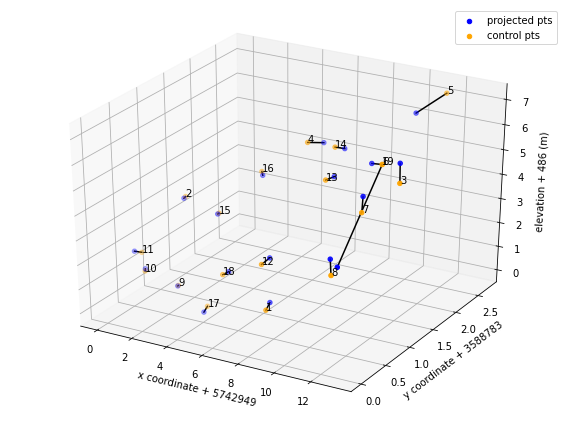

In [239]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
      
      https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to#13701747
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


fig = pl.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

#ax.set_aspect('equal')

leg_src = ax.scatter(srct_norm[:, 0], srct_norm[:, 1], srct_norm[:, 2], color='blue', label='projected pts')
leg_dst = ax.scatter(dst_norm[:, 0], dst_norm[:, 1], dst_norm[:, 2], color='orange', label='control pts')

for a, b in zip(srct_norm, dst_norm):
    ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]], color='black')

for i, a in enumerate(dst_norm):
    ax.text(a[0], a[1], a[2], str(i+1), zorder=101)

ax.set_xlabel('x coordinate + %0.0f' % x0)
ax.set_ylabel('y coordinate + %0.0f' % y0)
ax.set_zlabel('elevation + %0.0f (m)' % z0)

ax.legend()

#set_axes_equal(ax)
fig.tight_layout()

fn_out = os.path.join('fig', 'transform_error.pdf')

print('saving 3d fig with control points and projected location of control points as %s' % fn_out)

fig.savefig(fn_out)

## Save georeferenced pts to csv file

In [240]:
cols = ['id', 'source_x', 'source_y', 'target_x', 'target_y', 'projected_src_x', 'projected_src_y', 'transform_error']
index = np.arange(len(src))

df = pd.DataFrame(columns=cols, index=index)

df['id'] = cp['id']
df['source_x'] = src[:, 0]
df['source_y'] = src[:, 1]
df['target_x'] = dst[:, 0]
df['target_y'] = dst[:, 1]
df['projected_src_x'] = srct[:, 0]
df['projected_src_y'] = srct[:, 1]
df['transform_error'] = transform_error

fnc = 'georeferencing_results_control_pts.csv'
print('saving csv file with result georeferencing control points as %s' % fnc)

df.to_csv(fnc)

df.head()

saving csv file with result georeferencing control points as georeferencing_results_control_pts.csv


,id,source_x,source_y,target_x,target_y,projected_src_x,projected_src_y,transform_error
0,1.0,2026.600641,-2236.398594,5742957.092,3588783.315,5.742957e+06,3.588783e+06,0.279096
1,2.0,3745.403489,-1620.574986,5742950.091,3588784.181,5.742950e+06,3.588784e+06,0.061835
2,3.0,594.475281,-959.583088,5742961.891,3588784.179,5.742962e+06,3.588784e+06,0.303255
3,4.0,2465.584066,-1001.695166,5742955.344,3588784.760,5.742955e+06,3.588785e+06,0.309249
4,NaN,1303.852255,-612.002437,5742960.122,3588785.829,5.742959e+06,3.588785e+06,0.775715


## Load shapefile that should be projected

In [241]:
shp = gp.read_file(shpfile)
shp.head()

,geometry
0,"LINESTRING (518.362 -1139.601, 1464.451 -1400...."
1,"LINESTRING (1009.730 -1275.061, 987.286 -1395...."
2,"LINESTRING (623.263 -1319.963, 989.359 -1414.639)"
3,"LINESTRING (936.874 -1401.862, 944.354 -1494.726)"
4,"LINESTRING (539.561 -1413.767, 944.354 -1494.7..."


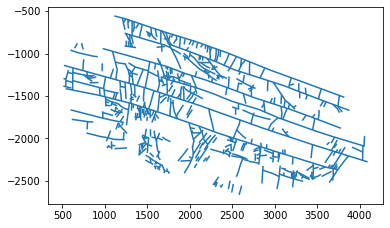

In [242]:
shp.plot()

## Project shapefile

In [243]:
gt = []

for g in shp.geometry:
    
    gc = np.array(g.coords[:])
    
    gct = transform_func(params_opt, gc, order)
    
    l = shapely.geometry.LineString(gct)
    
    gt.append(l)
    

In [244]:
#shp['geometry_backup'] = shp.geometry
shp_georef = shp.copy()
shp_georef.geometry = gt

## Save georeferenced shapefile

In [245]:
fn_out = shpfile[:-4] + '_georef.shp'

print('saving georeferenced shapefile as\n\t%s' % fn_out)

shp_georef.to_file(fn_out)

saving georeferenced shapefile as
	data/L48_1_MG_TM fractures_georef.shp


## Show the georeferenced shapefile in xy coords (map view)

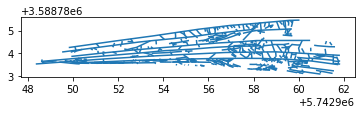

In [246]:
shp_georef.plot()

saving 3d figure of georeferenced shapefile as fig/L48_1_MG_TM fractures_georef_3d_fig.pdf


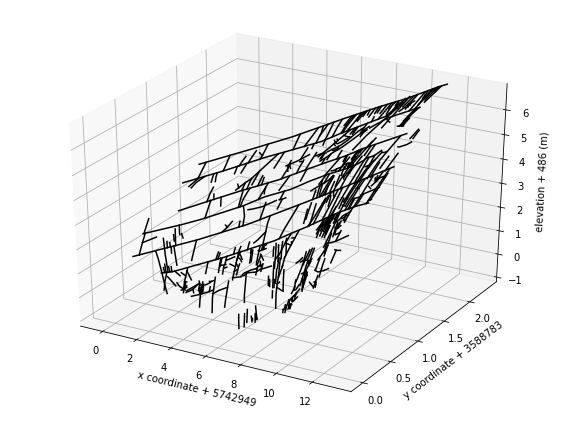

In [247]:
fig = pl.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for ls in shp_georef.geometry:
    #for ls in g:
    coords = np.array(ls.coords[:])

    ax.plot(coords[:, 0] - x0, coords[:, 1] - y0, coords[:, 2] - z0, color='black')
    
ax.set_xlabel('x coordinate + %0.0f' % x0)
ax.set_ylabel('y coordinate + %0.0f' % y0)
ax.set_zlabel('elevation + %0.0f (m)' % z0)

fig.tight_layout()

fn_out = os.path.join('fig', os.path.split(shpfile)[1][:-4] + '_georef_3d_fig.pdf')
print('saving 3d figure of georeferenced shapefile as %s' % fn_out)
fig.savefig(fn_out)

## Figure with 3d georeferenced shapefile projected to x, y and z plane

saving 2d figure of georeferenced shapefile as fig/L48_1_MG_TM fractures_georef_2d_fig.pdf


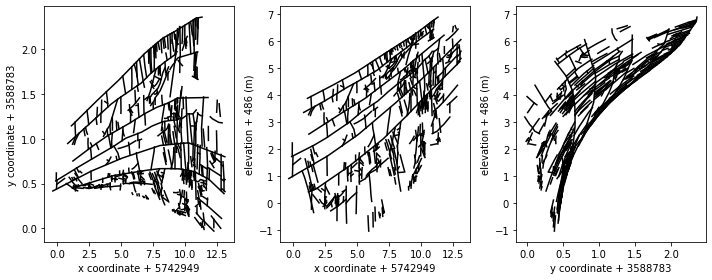

In [248]:
fig, axs = pl.subplots(1, 3, figsize=(10, 4))

for ls in shp_georef.geometry:
    #for ls in g:
    coords = np.array(ls.coords[:])

    axs[0].plot(coords[:, 0] - x0, coords[:, 1] - y0, color='black')
    axs[1].plot(coords[:, 0] - x0, coords[:, 2] - z0, color='black')
    axs[2].plot(coords[:, 1] - y0, coords[:, 2] - z0, color='black')

axs[0].set_xlabel('x coordinate + %0.0f' % x0)
axs[1].set_xlabel('x coordinate + %0.0f' % x0)
axs[0].set_ylabel('y coordinate + %0.0f' % y0)
axs[2].set_xlabel('y coordinate + %0.0f' % y0)
axs[1].set_ylabel('elevation + %0.0f (m)' % z0)
axs[2].set_ylabel('elevation + %0.0f (m)' % z0)

fig.tight_layout()

fn_out = os.path.join('fig', os.path.split(shpfile)[1][:-4] + '_georef_2d_fig.pdf')
print('saving 2d figure of georeferenced shapefile as %s' % fn_out)
fig.savefig(fn_out)

## Optional: Project the georefenced points to a plane

In [249]:
if project_shapefile is False:
    print('ending notebook here')
    exit()
else:
    print('proceeding with projection of georeferenced shapefile to a 2D plane')

proceeding with projection of georeferenced shapefile to a 2D plane


## Read file with points that define the plane to be projected to

In [250]:
pp = gp.read_file(plane_pt_file) 
pp

,id,northing,easting,elevation,geometry
0,2.0,5742959.543,3588784.72,491.175,POINT (610.707 -1775.014)
1,NaN,5742948.939,3588783.70,487.299,POINT (4038.409 -2085.556)


## Check if two or three points on the plane

In [251]:
try:
    assert len(pp) >= 2
except:
    msg = 'need at least two points to define a plane'
    raise IndexError(msg)

# get coordinates of the plane
px = pp[pp_x_col].values
py = pp[pp_y_col].values
pz = pp[pp_z_col].values

if len(pp) == 2:
    print('found two points to define the plane. Assuming the plane is vertical and the third point is located above point 1')
    origin_id = np.argmin(px)
    px = np.append(px, px[origin_id])
    py = np.append(py, py[origin_id])
    xy_dist = np.sqrt((px[1] - px[0])**2 + (py[1] - py[0])**2)
    print('adding total hor distance of %0.2f to the vertical axis ' % xy_dist)
    pz = np.append(pz, pz[origin_id] + xy_dist)
    
print('using the following points to define the plane:')
print(list(zip(px, py, pz)))

found two points to define the plane. Assuming the plane is vertical and the third point is located above point 1
adding total hor distance of 10.65 to the vertical axis 
using the following points to define the plane:
[(5742959.543, 3588784.72, 491.175), (5742948.939, 3588783.7, 487.299), (5742948.939, 3588783.7, 497.95194400559257)]


In [252]:
# define origin of the plane
x0 = px.min()
y0 = py.min()
z0 = pz.min()

# sort points to make sure the origin is the first pt
pxi = px.copy()
pyi = py.copy()
pzi = pz.copy()

origin_id = np.argmin(pxi)
vert_id = np.argmax(pzi)
ids = [origin_id, vert_id]
res = [i for i in [0, 1, 2] if i not in ids][0] 
new_ids = np.array([origin_id, res, vert_id])

px = pxi[new_ids]
py = pyi[new_ids]
pz = pzi[new_ids]

pxr = px - x0
pyr = py - y0
pzr = pz - z0

print('plane coordinates are relative to origin of')
print('x0 = %0.2f, y0=%0.2f, z0=%0.2f\n' % (x0, y0, z0))

print('\nrelative coordinates plane:\n', list(zip(pxr, pyr, pzr)))

plane = sympy.Plane(sympy.Point3D(pxr[0], pyr[0], pzr[0]),
                    sympy.Point3D(pxr[1], pyr[1], pzr[1]),
                    sympy.Point3D(pxr[2], pyr[2], pzr[2]))

print('\nequation of the plane = %s' % str(plane.equation()))

a = plane.equation()

b = a.as_coeff_add()
plane_coeffs = [bi.as_coeff_Mul()[0].round(3) for bi in b[1]]
plane_coeffs.append(b[0].round(3))

if len(plane_coeffs) == 4:
    print('\nsimplified eq. of the plane = %0.3f z + %0.3fx + %0.3f y + %0.3f' 
          % (plane_coeffs[0], plane_coeffs[1], plane_coeffs[2], plane_coeffs[3]))
elif len(plane_coeffs) == 3:
    print('\nthe plane appears to be vertical')
    print('\nsimplified eq. of the plane = %0.3fx + %0.3f y + %0.3f' 
          % (plane_coeffs[0], plane_coeffs[1], plane_coeffs[2]))

plane coordinates are relative to origin of
x0 = 5742948.94, y0=3588783.70, z0=487.30


relative coordinates plane:
 [(0.0, 0.0, 0.0), (10.6039999993518, 1.0200000000186265, 3.876000000000033), (0.0, 0.0, 10.652944005592587)]

equation of the plane = 5433001442951458173412095069*x/500000000000000000000000000 - 2824095455709967302389371917*y/25000000000000000000000000

the plane appears to be vertical

simplified eq. of the plane = -112.964x + 10.866 y + 0.000


## Select two vectors that lie in the plane

In [253]:
vect1_xy = [[pxr[0], pyr[0], pzr[0]], [pxr[1], pyr[1], pzr[1]]]
vect2_xy = [[pxr[0], pyr[0], pzr[0]], [pxr[2], pyr[2], pzr[2]]]

vect1_xy_array = np.array(vect1_xy)
vect2_xy_array = np.array(vect2_xy)

vect1 = shapely.geometry.LineString(vect1_xy)
vect2 = shapely.geometry.LineString(vect2_xy)

#vect1, vect2
#vp1 = gp.GeoSeries(vect1)
#vp2 = gp.GeoSeries(vect2)
#vp1.plot()
#vp2.plot()


## Make a 3d figure of the georeferenced shapefile and the two vectors

saving 3d figure of georeferenced shapefile as fig/L48_1_MG_TM fractures_georef_3d_fig_v2.pdf


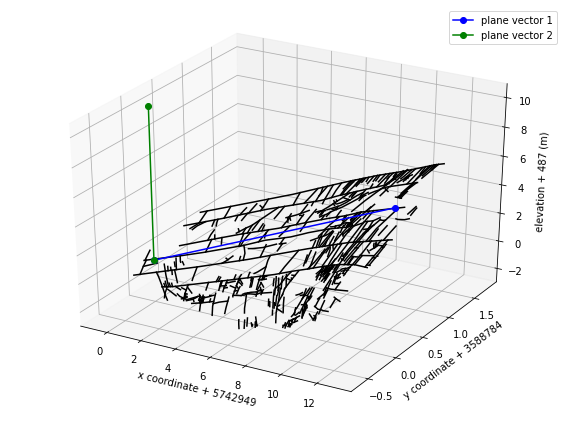

In [254]:
fig = pl.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for ls in shp_georef.geometry:
    #for ls in g:
    coords = np.array(ls.coords[:])

    ax.plot(coords[:, 0] - x0, coords[:, 1] - y0, coords[:, 2] - z0, color='black')

ax.plot(vect1_xy_array[:, 0], vect1_xy_array[:, 1], vect1_xy_array[:, 2], label='plane vector 1', color='blue', marker='o')
ax.plot(vect2_xy_array[:, 0], vect2_xy_array[:, 1], vect2_xy_array[:, 2], label='plane vector 2', color='green', marker='o')

ax.set_xlabel('x coordinate + %0.0f' % x0)
ax.set_ylabel('y coordinate + %0.0f' % y0)
ax.set_zlabel('elevation + %0.0f (m)' % z0)

ax.legend()

fig.tight_layout()

fn_out = os.path.join('fig', os.path.split(shpfile)[1][:-4] + '_georef_3d_fig_v2.pdf')
print('saving 3d figure of georeferenced shapefile as %s' % fn_out)
fig.savefig(fn_out)

## Projection onto a plane using shapely

projection on to a plane defined by two vectors. Using shapely to get the projected points and distance along each vector for the projected point

In [255]:
def ClosestPointOnLine(a, b, p):
    '''
    
    https://gamedev.stackexchange.com/questions/72528/how-can-i-project-a-3d-point-onto-a-3d-line
       
    ''' 
    ap = p - a
    ab = b - a
    
    result = a + np.dot(ap, ab) / np.dot(ab, ab) * ab
    
    return result


def projected_distance(a, b, p):
    
    # find the projected point
    projected_pt = ClosestPointOnLine(a, b, p)
    
    # find the distance between the projected pt and the origin (which is assumed to be a)
    distance = np.sqrt((projected_pt[0] - a[0])**2 + (projected_pt[1] - a[1])**2 + (projected_pt[2] - a[2])**2 )
    
    return distance


prs = np.array(list(zip(pxr, pyr, pzr)))

gpr = []

print('start projecting lines onto a plane defined by two vectors')
print('note: this may take a while....')

for i, g in enumerate(shp_georef.geometry):
    
    if int(i/100) == float(i/100):
        print('processing line segment %i of %i' % (i+1, len(shp_georef.geometry)))
    
    gc = np.array(g.coords[:])
    
    # convert the georeferenced coords to relative coords
    gc[:, 0] = gc[:, 0] - x0
    gc[:, 1] = gc[:, 1] - y0
    gc[:, 2] = gc[:, 2] - z0
    
    #gcmp = shapely.geometry.MultiPoint(gc)
    
    gcp = []
    
    for gci in gc:
        
        #dx = vect1.project(gci)
        #dy = vect2.project(gci)
        dx = projected_distance(prs[0], prs[1], gci)
        dy = projected_distance(prs[0], prs[2], gci)
        
        gcp.append([dx, dy])
        
    #gcp_sympy = [plane.projection(sympy.Point3D(gci[0], gci[1], gci[2])) for gci in gc]
    
    #gcp = [[gi.x.round(2), gi.y.round(2), gi.z.round(2)] for gi in gcp_sympy]
    
    l = shapely.geometry.LineString(gcp)
    
    gpr.append(l)
    
print('done projecting')

start projecting lines onto a plane defined by two vectors
note: this may take a while....
processing line segment 1 of 468
processing line segment 101 of 468
processing line segment 201 of 468
processing line segment 301 of 468
processing line segment 401 of 468
done projecting


In [256]:
gc, prs, gcp

(array([[1.67241373, 0.027585  , 0.06089488],
        [1.53411479, 0.0450683 , 0.19409509]]),
 array([[ 0.        ,  0.        ,  0.        ],
        [10.604     ,  1.02      ,  3.876     ],
        [ 0.        ,  0.        , 10.65294401]]),
 [[1.5877012693700947, 0.06089487717099473],
  [1.5054507847295293, 0.19409508967896727]])

## Add new projected geometry to modified shapefile

In [257]:
shp_proj = shp_georef.copy()
shp_proj.geometry = gpr

## Save projected shapefile

In [258]:
fn_out = shpfile[:-4] + '_projected_to_plane.shp'

print('saving shapefile that was projected onto a plane as\n\t%s' % fn_out)

shp_proj.to_file(fn_out)

saving shapefile that was projected onto a plane as
	data/L48_1_MG_TM fractures_projected_to_plane.shp


## Show new shapefile projected onto a plane

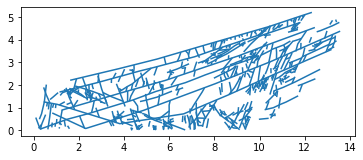

In [259]:
shp_proj.plot()

## Show original shapefile

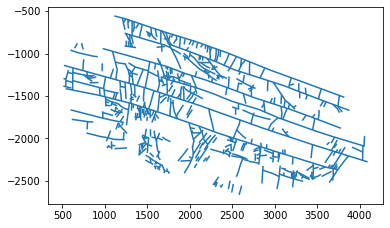

In [260]:
shp.plot()

## Projection onto a plane using sympy

Works with getting projected point coordinates (in 3D) but then still would need to convert this to new x and y coordinates along the plane. Not sure how to do this, sympy does not have an option to project to a vector/line...

In [261]:
use_sympy_proj = False

if use_sympy _proj is True:

    gpr = []

    print('start projecting lines onto a plane')
    print('note: this may take a while....')

    for i, g in enumerate(shp.geometry):

        if int(i/10) == float(i/10):
            print('processing line segment %i of %i' % (i+1, len(shp.geometry)))

        gc = np.array(g.coords[:])

        # convert the georeferenced coords to relative coords
        gc[:, 0] = gc[:, 0] - x0
        gc[:, 1] = gc[:, 1] - y0
        gc[:, 2] = gc[:, 2] - z0

        gcp_sympy = [plane.projection(sympy.Point3D(gci[0], gci[1], gci[2])) for gci in gc]

        gcp = [[gi.x.round(2), gi.y.round(2), gi.z.round(2)] for gi in gcp_sympy]

        l = shapely.geometry.LineString(gcp)

        gpr.append(l)

    print('done projecting')
    
    fn_out = shpfile[:-4] + '_projected_to_plane_with_sympy.shp'

    print('saving shapefile that was projected onto a plane as\n\t%s' % fn_out)

    shp.to_file(fn_out)

SyntaxError: invalid syntax (<ipython-input-261-50ee893710ba>, line 3)

In [ ]:
shp_proj.geometry = gpr